#**EDA를 통한 변수 추가 모델**

In [ ]:
# 내 드라이브에 대한 주소
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = "/gdrive/My Drive/dacon_news"

train = pd.read_csv(path + "/data/news_train.csv")
test = pd.read_csv(path + "/data/news_test.csv")

In [ ]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is already installed'
mecab-ko is already installed
+ [[ -d /usr/local/lib/mecab/dic/mecab-ko-dic ]]
+ echo 'mecab-ko-dic is already installed'
mecab-ko-dic is already installed
++ python3 -c 'import pkgutil; print(1 if pkgutil.find_loader("MeCab") else 0)'
+ [[ 1 == \1 ]]
+ echo 'mecab-python is already installed'
mecab-python is already installed
+ echo Done.
Done.


# content내용이 다음과 같으면 무조건 0이기 때문에 훈련에서 제외
- 종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지

In [ ]:
train = train.loc[train["content"]!="종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지",:]

# 타이틀을 이용한 feature
- 해당 title에 몇가지 단어가 들어갈 경우 약 90% 이상이 info가 1

In [ ]:
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '▶' ,'◆','★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
    for noise in title_noise:
        if noise in x["title"].upper():
          if (x["content"][:2]=="제목") or (x["content"][:1]=="["):
            return 0
          else:
            return 1
        elif (x["title"][-2:] == "종목") or (x["title"][-4:] == '관련주"'):
            return 1
        elif (x["content"]=="코스피") or (x["content"]=="코스닥"):
          return 1
    return 0

In [ ]:
train["info1_title"]=train.apply(title_choose, axis=1)

# info가 1인 content에서 자주 등장하는 단어를 포함한 content를 1로하는 feature 추가

In [ ]:
def in_bull(x):
    info_list = ['공개','추천','상한','무료','주식','바이오','금리','테마','탁론','카톡','실적',
                 '수익', '미수', '수혜주','급등', 'http', '하이스',"]]"]
    for i in info_list:
        if i in x:
            return 1
    return 0
train["info1_words"]=train["content"].apply(in_bull)

# tokenization

In [ ]:
from konlpy.tag import Mecab
import re
from konlpy.tag import Okt

def text_preprocessing(text_list):
    
    stopwords = [] #불용어 설정
    
    tokenizer = Mecab() #형태소 분석기 
    token_list = [] 
    
    for text in text_list:
        txt = re.sub('[^가-힣]', ' ', text) #한글만 남기고 다른 글자 모두 제거
        txt = re.sub('[가-힣\s]+기자]','기자', txt) #기자 이름 제거
        token = tokenizer.morphs(txt) #형태소 분석

        #형태소 분석 결과 중 stopwords에 해당하지 않고, float type이 아닌 것만 수집
        token = [t for t in token if t not in stopwords and type(t) != float] 
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다. 
train['new_article'], okt = text_preprocessing(train['content'])

In [ ]:
# 결측치 제거
train = train[train["new_article"].apply(lambda x: False if len(x)==0 else True)]

# Vectorization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=1000):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len) # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = 100)
print(train_X.shape, train_y.shape)

vocab_size :  33443
(118140, 100) (118140,)


In [ ]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
path = "/gdrive/My Drive/dacon_news"

In [ ]:
# 구글 word2vec 모델
word2vec = gensim.models.KeyedVectors.load_word2vec_format(path+'/embedding/GoogleNews-vectors-negative300.bin.gz', binary = True)

In [ ]:
# 한국어 word2vec model
word2vec2 = gensim.models.Word2Vec.load(path+'/embedding/ko.bin')

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))
vocab = vectorizer.word_index
count = 0

for idx, word in enumerate(vocab):
    if word in word2vec2:
      embedding_vector = word2vec2[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
      print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass
      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
임이자 word2vec에 없는 단어입니다.
이한성 word2vec에 없는 단어입니다.
전상헌 word2vec에 없는 단어입니다.
강부 word2vec에 없는 단어입니다.
장세호 word2vec에 없는 단어입니다.
정희용 word2vec에 없는 단어입니다.
권수현 word2vec에 없는 단어입니다.
소방위 word2vec에 없는 단어입니다.
김서영 word2vec에 없는 단어입니다.
밝혔으나 word2vec에 없는 단어입니다.
에퀴 word2vec에 없는 단어입니다.
우성문 word2vec에 없는 단어입니다.
기우뚱 word2vec에 없는 단어입니다.
손형주 word2vec에 없는 단어입니다.
기울어진 word2vec에 없는 단어입니다.
그린코 word2vec에 없는 단어입니다.
연약지반 word2vec에 없는 단어입니다.
개였 word2vec에 없는 단어입니다.
허심탄회 word2vec에 없는 단어입니다.
끝냈으면 word2vec에 없는 단어입니다.
김계환 word2vec에 없는 단어입니다.
발선 word2vec에 없는 단어입니다.
돗 word2vec에 없는 단어입니다.
바통 word2vec에 없는 단어입니다.
당우 word2vec에 없는 단어입니다.
석패 word2vec에 없는 단어입니다.
개각 word2vec에 없는 단어입니다.
오월동주 word2vec에 없는 단어입니다.
뒤졌 word2vec에 없는 단어입니다.
법심 word2vec에 없는 단어입니다.
담상 word2vec에 없는 단어입니다.
가와이 word2vec에 없는 단어입니다.
가쓰유키 word2vec에 없는 단어입니다.
점찍 word2vec에 없는 단어입니다.
기시다 word2vec에 없는 단어입니다.
후미오 word2vec에 없는 단어입니다.
다로 word2vec에 없는 단어입니다.
뉘른베르크 word2vec에 없는 단어입니다.
도미이치 word2vec에 없는 단어입니다.
공통분모 word2vec에 없는 단어입니다.
억지력 word

In [ ]:
count

17727

#train test split

In [ ]:
#train_X = np.concatenate([train_X,train[["info1_words","info1_title"]].values.reshape(-1,2)], axis=1)
train_X = np.concatenate([train_X,train["info1_title"].values.reshape(-1,1)], axis=1)

In [ ]:
# 문장별로 train_test set 분리
from sklearn.model_selection import train_test_split

#num_article = len(train["n_id"].unique())
#trainnp.random.randint(0,num_article,int(0.7*num_article))

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 42, test_size = 0.3)

#모델링 비교

1. embedding vector만을 통한 모델링

In [ ]:
# EDA기반으로 만든 feature 예측변수로 추가
from keras import regularizers

def LSTM_add_feature(vocab_size, embedding_size = 200, max_len=100):
  input1 = keras.layers.Input(shape = [100,]) #문장 단어 input
  input2 = keras.layers.Input(shape = [1,]) # EDA기반 feature input

  # LSTM
  embedding = keras.layers.Embedding(vocab_size, embedding_size, weights = [embedding_matrix], input_length = max_len)(input1) # 임베딩 가중치 적용
  dropout1 = keras.layers.SpatialDropout1D(0.3)(embedding)
  lstm1 = keras.layers.LSTM(32, return_sequences = True)(dropout1)
  lstm2 = keras.layers.LSTM(32)(lstm1)
  dropout2 = keras.layers.Dropout(0.5)(lstm2)
  #lstm_output = keras.layers.Dense(16, activation = "selu")(dropout2)

  # MLP
  concat = keras.layers.concatenate([dropout2,input2])
  hidden = keras.layers.Dense(16, activation = "selu")(concat)
  output = keras.layers.Dense(1, activation = "sigmoid")(hidden)

  model = keras.Model(inputs = [input1, input2], outputs = [output])

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model


In [ ]:
# 훈련 시
tf.random.set_seed(42)


checkpoint_cb = keras.callbacks.ModelCheckpoint("hyerim_add_feature_best_model2.h5",
                                               save_best_only = True)

# 하이퍼파라미터
max_epoch = 5
batch_size = 100
learning_rate = 0.001

model = LSTM_add_feature(vocab_size)
history = model.fit(x=[X_train[:,:-1],X_train[:,-1:]], y=y_train,epochs=max_epoch,
                batch_size = batch_size,  validation_data = ((X_valid[:,:-1],X_valid[:,-1:]),y_valid), validation_batch_size = batch_size,
                 callbacks = [checkpoint_cb])

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 200, 200)     6688600     input_23[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_11 (SpatialDr (None, 200, 200)     0           embedding_11[0][0]               
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 32)           29824       spatial_dropout1d_11[0][0]       
______________________________________________________________________________________

In [ ]:
best_model = keras.models.load_model("hyerim_add_feature_best_model.h5") # 저장된 모델 불러오기
plt.plot(pd.DataFrame(history.history))

In [ ]:
best_model.evaluate((X_valid[:,:-1],X_valid[:,-1:]),y_valid)

1108/1108 [==============================] - 15s 14ms/step - loss: 0.0730 - accuracy: 0.9768


[0.0730186253786087, 0.9768353700637817]

In [ ]:
# 성능
best_model.evaluate((X_valid[:,:-1],X_valid[:,-1:]),y_valid)

# 최종 훈련

In [ ]:
# 실제 예측시

tf.random.set_seed(42)

# 하이퍼파라미터
max_epoch = 4
batch_size = 100
learning_rate = 0.001

model = LSTM_add_feature(vocab_size)
history = model.fit(x=[train_X[:,:-1],train_X[:,-1:]], y=train_y,epochs=max_epoch,batch_size = batch_size)

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 300, 300)     9677100     input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 300, 300)     0           embedding_9[0][0]                
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 32)           42624       spatial_dropout1d_9[0][0]        
______________________________________________________________________________________

KeyboardInterrupt: ignored

# test 예측

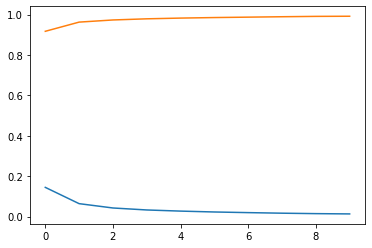

In [ ]:
plt.plot(pd.DataFrame(history.history))

In [ ]:
model.save('final_model.h5')

In [ ]:
test = pd.read_csv(path+"news_test.csv")

test["info1_title"]=test.apply(title_choose, axis=1)
#test["info1_words"]=test["content"].apply(in_bull)

test['new_article'], okt = text_preprocessing(test['content'])
test_X_seq = vectorizer.texts_to_sequences(test["new_article"])
test_X = pad_sequences(test_X_seq, maxlen = 100) # 길이를 맞춰줌

test_X = np.concatenate([test_X,test["info1_title"].values.reshape(-1,1)], axis=1)

In [ ]:
final_model = keras.models.load_model("final_model.h5") # 저장된 모델 불러오기
predicted = final_model.predict([test_X[:,:-1],test_X[:,-1:]])

In [ ]:
test["info"]=predicted
predicted[test["content"]=="종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지"]=0

In [ ]:
submission = pd.read_csv(path+"/data/sample_submission.csv")
submission["info"]=test["info"]>=0.85
submission.to_csv("hyerim_submission2.csv", encoding="utf-8-sig",index=False)

In [ ]:
submission

,id,info
0,NEWS00237_1,0.0
1,NEWS00237_2,0.0
2,NEWS00237_3,0.0
3,NEWS00237_4,0.0
4,NEWS00237_5,0.0
...,...,...
142560,NEWS09482_72,1.0
142561,NEWS09482_73,1.0
142562,NEWS09482_74,1.0
142563,NEWS09482_75,1.0
